<h2>ToDo</h2>
<ul>
    <li>ask for estimate of layer borders (current density estimate)</li>
    <li>create artifical data and run analysis on it</li>
    <li>check, whether additive model makes sense (and whether hierarchical inference is even in here?!)</li>
    <li>obtain biological parameters from inference</li>   
    <li>migrate notebook to shared notebook, or find some other good way to work on it collaboratively</li>
    <li>migrate code to python code and change notebook to accessing the "API" only</li>
    <li>migrate data reading to python code and merely call it on the data (with path)</li>
</ul>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio

<h1>Data preprocessing</h1>
<p>Currently, data is read in from experimental dataset</p>
<p>Should contain option to create data from model</p>

In [3]:
def compDiff(a,b,classify):
    comp = True
    for c in classify:
        #print(a[c],b[c])
        if type(a[c])==np.ndarray:
            comp = comp and np.array_equal(a[c],b[c])
            #print('is array')
        else:
            comp = comp and a[c]==b[c]
        #print(comp)
    #print('overall:',comp)
    return comp

In [4]:
### specifying parameters

# location of data file
filePath = '../../data/BuscheLab/spiking_data_for_modeling_with_depth.mat'

# list, specifying data along which to cluster
classify = ['spikes_animal_idx','spikes_hemisphere_idx','spikes_genotype']
### read data from file
f = h5py.File(filePath,'r')
data = {}
for key in f.keys():
    data[key] = np.array(f.get(key))

### preprocess data where needed
data['spikes_genotype'] = []
for spike_genotype_ref in data['spikes_genotype_idx']:
    data['spikes_genotype'].append(np.array(f[spike_genotype_ref[0]]))

data['spikes_animal_idx'] = data['spikes_animal_idx'].flatten()
data['spikes_cluster_idx'] = data['spikes_cluster_idx'].flatten()
data['spikes_hemisphere_idx'] = data['spikes_hemisphere_idx'].flatten()
data['spikes_depth_rel2L5'] = data['spikes_depth_rel2L5'].flatten()

In [5]:
### Compart neurons into layers
layer_border = [-1000,-250,200,1000]
depth = np.array(data['spikes_depth_rel2L5'])
data['layer'] = np.zeros((len(depth)),'int')
for l in range(len(layer_border)-1):
    #print((layer_border[l-1] < depth) & (depth < layer_border[l]))
    data['layer'][(layer_border[l] <= depth) & (depth < layer_border[l+1])] = l
    print(l,layer_border[l],layer_border[l+1], sum(data['layer']==l))
#print(data['layer'])
#print(data['spikes_depth_rel2L5'])

0 -1000 -250 779
1 -250 200 535
2 200 1000 101


In [6]:
### clustering data
spike_data = []
for n in range(len(data['spikes_animal_idx'])):
    ### create classification dictionary
    tmp_class = {}
    for c in classify:
        tmp_class[c] = data[c][n]
    #print(tmp_class)
    
    ### search, whether this set of data already exists
    idx = None
    for i,sd in enumerate(spike_data):
        #print('classification',sd['classification'])
        if compDiff(tmp_class,sd['classification'],classify):
            idx = i
            break
    
    ### create new cluster if idx not found
    if idx==None:
        idx = len(spike_data)
        spike_data.append({
            'classification': tmp_class,
            'spike_times': [],
            'neuron_idx': [],
            'cluster_idx': [],
            'layer': [],
            'depth': [],
        })
    
    spike_data[idx]['spike_times'].append(np.array(f[data['spikes_timestamps'][n][0]])[0])
    spike_data[idx]['neuron_idx'].append(n)
    spike_data[idx]['cluster_idx'].append(data['spikes_cluster_idx'][n])
    spike_data[idx]['layer'].append(data['layer'][n])
    spike_data[idx]['depth'].append(data['spikes_depth_rel2L5'][n])

In [7]:
### some processing

### sort neurons according to type
sort_keys = ['neuron_idx','cluster_idx','spike_times']
for sd in spike_data:
    sort_idx = np.argsort(sd['cluster_idx'])
    
    sd_tmp = {}
    for key in sort_keys:
        data_tmp = []
        for i,n in enumerate(sort_idx):
            data_tmp.append(sd[key][n])
        sd[key] = data_tmp
    sd['cluster_idx'] = np.array(sd['cluster_idx'])
        
### calculate some statistics
## firing rate
for sd in spike_data:
    sd['N'] = len(sd['neuron_idx']) # total number of recorded neurons
    sd['g'] = np.array([np.sum(np.array(sd['cluster_idx'])==a) for a in range(3)])/sd['N'] # fraction of neuron belonging to cluster a
    
    sd['T'] = max([max(s) for s in sd['spike_times']]) # recording time (estimated from very last spike encountered in this animal)
    
    nIntervals = 6
    dT = sd['T']/nIntervals
    sd['rate'] = np.zeros((sd['N'],nIntervals+1))
    for n,s in enumerate(sd['spike_times']):
        sd['rate'][n,0] = len(s)/sd['T']
        for i in range(nIntervals):
            sd['rate'][n,i+1] = np.sum((s>i*dT) & (s<(i+1)*dT))/dT

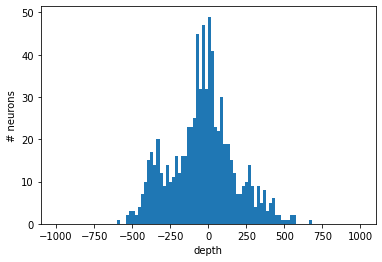

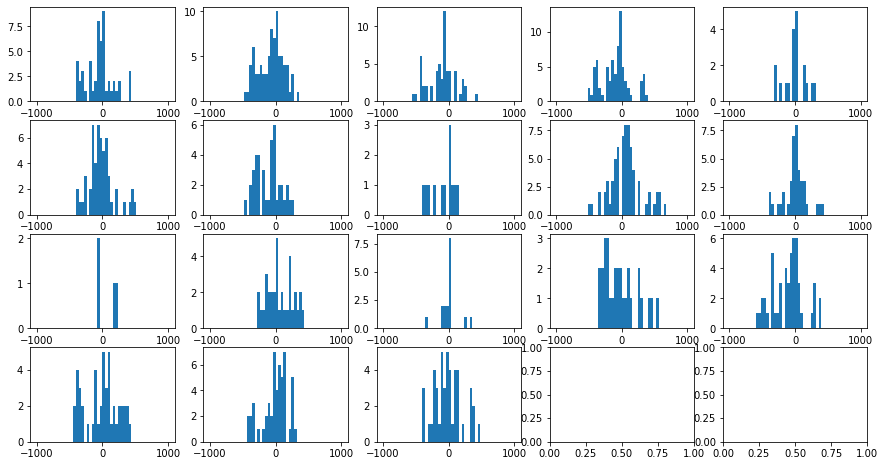

In [11]:
_ = plt.hist(data['spikes_depth_rel2L5'],np.linspace(-1000,1000,101))
plt.xlabel('depth')
plt.ylabel('# neurons')

fig,ax = plt.subplots(4,5,figsize=(15,8))
for i,animal in enumerate(spike_data):
    _ = ax[i//5][i%5].hist(animal['depth'],np.linspace(-1000,1000,51))
    

In [12]:
spike_data[1]['rate'].shape

(81, 7)

In [12]:
from matplotlib.widgets import Slider

def plot_animal(animal,ax,j=0):
    
    i=0
    for sd in spike_data:
        if sd['classification']['spikes_animal_idx'] == animal:

            for n in range(len(sd['neuron_idx'])):
                nAP = len(sd['spike_times'][n])
                col = 'gray'
                if sd['cluster_idx'][n] == 1.:
                    col = 'k'
                elif sd['cluster_idx'][n] == 2.:
                    col = 'r'
                ax[i][0].plot(sd['spike_times'][n],np.ones(nAP)*n,'.',markersize=2,color=col)
            ax[i][0].set_title(f'animal {int(animal)}' \
                                + f'{"l" if sd["classification"]["spikes_hemisphere_idx"]==1 else "r"}' \
                                + f' {"cre" if sd["classification"]["spikes_genotype"][1]==114 else "cTKO"}')
            ax[i][1].hist(sd['rate'][sd['cluster_idx']==1,j],np.linspace(0,5,51),facecolor='k',alpha=0.8)
            ax[i][1].hist(sd['rate'][sd['cluster_idx']==0,j],np.linspace(0,5,51),facecolor='gray',alpha=0.8)
            ax[i][1].hist(sd['rate'][sd['cluster_idx']==2,j],np.linspace(0,5,51),facecolor='r',alpha=0.8)
            
            i+=1
    plt.tight_layout()

In [13]:
nAnimals = len(np.unique(data['spikes_animal_idx']))

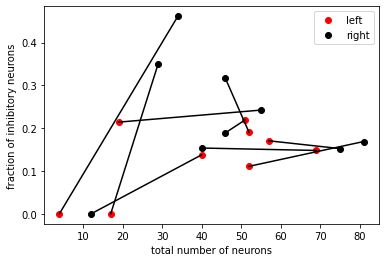

In [17]:
r = np.zeros((nAnimals,2))
N = np.zeros((nAnimals,2))

for sd in spike_data:
    a = int(sd['classification']['spikes_animal_idx'])-1
    h = int(sd['classification']['spikes_hemisphere_idx'])-1
    #l = int(sd['classification']['layer'])-1
    r[a,h] = sd['g'][2]/np.sum(sd['g'][1:])
    N[a,h] = sd['N']
    #r[a,l] = sd['g'][2]/np.sum(sd['g'][1:])
    #N[a,l] = sd['N']
plt.plot(N[:,0],r[:,0],'ro',label='left')
plt.plot(N[:,1],r[:,1],'ko',label='right')
plt.plot(N.T,r.T,'k-')

#print('fraction of inhibitory neurons: ', r)
plt.ylabel('fraction of inhibitory neurons')
plt.xlabel('total number of neurons')
plt.legend()

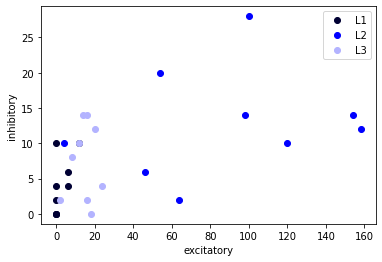

In [40]:
N = np.zeros((nAnimals,3,3))

for a in range(nAnimals):
    for h in range(2):
        for l in range(3):
            for c in range(3):
                for sd in spike_data:
                    if int(sd['classification']['spikes_animal_idx'])-1==a:
                        idx = (np.array(sd['layer'])==l) & (sd['cluster_idx']==c)
                        N[a,l,c] += idx.sum()
N[8,...]

plt.plot(N[:,0,1],N[:,0,2],'o',color=[0,0,0.2],label='L1')
plt.plot(N[:,1,1],N[:,1,2],'o',color=[0,0,1],label='L2')
plt.plot(N[:,2,1],N[:,2,2],'o',color=[0.7,0.7,1],label='L3')
plt.xlabel('excitatory')
plt.ylabel('inhibitory')

plt.legend()

In [16]:
for idx in range(18):
    print(spike_data[idx]['classification'],len(spike_data[idx]['layer']),len(spike_data[idx]['cluster_idx']))

{'spikes_animal_idx': 1.0, 'spikes_hemisphere_idx': 1.0, 'spikes_genotype': array([[ 99],
       [114],
       [101],
       [ 45]], dtype=uint16)} 52 52
{'spikes_animal_idx': 1.0, 'spikes_hemisphere_idx': 2.0, 'spikes_genotype': array([[ 99],
       [114],
       [101],
       [ 45]], dtype=uint16)} 81 81
{'spikes_animal_idx': 2.0, 'spikes_hemisphere_idx': 1.0, 'spikes_genotype': array([[ 99],
       [114],
       [101],
       [ 45]], dtype=uint16)} 57 57
{'spikes_animal_idx': 2.0, 'spikes_hemisphere_idx': 2.0, 'spikes_genotype': array([[ 99],
       [114],
       [101],
       [ 45]], dtype=uint16)} 75 75
{'spikes_animal_idx': 3.0, 'spikes_hemisphere_idx': 1.0, 'spikes_genotype': array([[ 99],
       [114],
       [101],
       [ 45]], dtype=uint16)} 19 19
{'spikes_animal_idx': 3.0, 'spikes_hemisphere_idx': 2.0, 'spikes_genotype': array([[ 99],
       [114],
       [101],
       [ 45]], dtype=uint16)} 55 55
{'spikes_animal_idx': 4.0, 'spikes_hemisphere_idx': 1.0, 'spikes_genotype': 

In [17]:
spike_data[9]['classification']

{'spikes_animal_idx': 5.0,
 'spikes_hemisphere_idx': 2.0,
 'spikes_genotype': array([[ 99],
        [114],
        [101],
        [ 45]], dtype=uint16)}

/tmp/ipykernel_60573/626928529.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


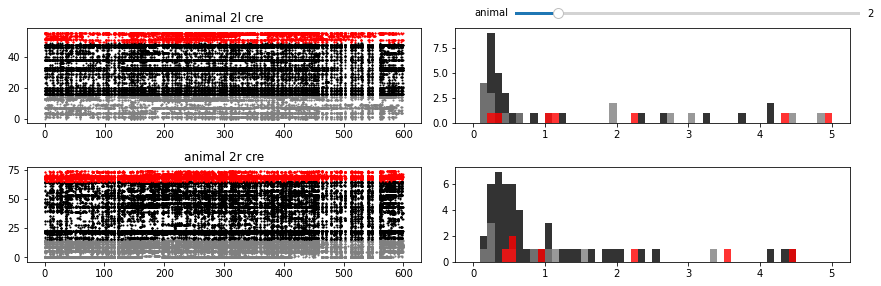

In [19]:
#fig,ax = plt.subplots(2,2,figsize=(12,4))

def change_slider(animal):
    print(animal)
    plot_animal(animal,ax)

animal = 2

#plot_animal(animal,ax,1)

fig,ax = plt.subplots(2,2,figsize=(12,4))
axamp = plt.axes([0.6, .95, 0.4, 0.02])
slider = Slider(axamp, 'animal', 1, 9, valinit=animal,orientation='horizontal')
slider.on_changed(change_slider)
plot_animal(animal,ax,0)


In [57]:
#from create_measures import *

class ModelParams:
    
    def __init__(self):
        
        self._num_layers = 3
        self._num_clusters = 2
        
    
    def empirical_data(self,data):
        self._num_animals = len(data)
        self.modelShape = (self._num_animals,self._num_layers,self._num_clusters)
        
        self.spikes = np.zeros(self.modelShape + (0,))
        spikes_shape = self.spikes.shape
        for a,sd in enumerate(data):
            
            for l in range(self._num_layers):
                
                for c in range(2):
                    
                    idx = (np.array(sd['layer'])==l) & (sd['cluster_idx']-1==c)
                    nSpikes = idx.sum()
                    if nSpikes > spikes_shape[-1]:
                        self.spikes = np.pad(self.spikes,((0,0),(0,0),(0,0),(0,nSpikes-spikes_shape[-1])),'constant',constant_values=np.NaN)
                        spikes_shape = self.spikes.shape
                    
                    self.spikes[a,l,c,:nSpikes] = sd['rate'][idx,0]
        
        self.nMax = spikes_shape[-1]
        
        self.spikes = np.transpose(self.spikes,(3,0,1,2))
        self.mask = ~np.isnan(self.spikes)
        self.spikes = self.spikes[self.mask]
        #self.spikes = self.spikes.flatten()
    
    def artificical_data(self,):
        
        arr_rateWnt = [1.,2.,5.]
        arr_alpha_0 = [0.0,0.02,0.06]
        
        for L in range(arr_rateWnt):
            res = create_measures(L=1,S=[1,2],N=100,rerun=True,rateWnt=1.,alpha_0=0.02,)
                    

exp_data = spike_data#[:10]
mP = ModelParams()
mP.empirical_data(exp_data)

In [58]:
print(mP.spikes.shape)

mP.spikes
mP.modelShape

(585,)


(18, 3, 2)

In [59]:
a = np.random.rand(3,4,2)
b = np.tile(a,(5,1,1,1))
b.shape

(5, 3, 4, 2)

In [60]:
def construct_gamma(name,mP,sigma_layer=1.0,sigma_animal=1.0,sigma_cluster=1.0):
    
    ## build gamma as a base value + modifications per layer and per animal
    # gamma = gamma_base + delta_gamma_layer (N(0,sigma_layer)) + delta_gamma_animal (N(0,sigma_animal))
    
    sigma_gamma_base = pm.HalfNormal('sigma_gamma',sigma=1.);
    #gamma_base = pm.HalfNormal('gamma_base',sigma=sigma_gamma_base,shape=(mP._num_animals,mP._num_layers,2));
    gamma_base = pm.HalfNormal('gamma_base',sigma=sigma_gamma_base);
    
    delta_gamma_animal = pm.Normal('delta_gamma_animal',mu=0,sigma=sigma_animal, shape=(mP._num_animals,1,1))
    delta_gamma_layer = pm.Normal('delta_gamma_layer',mu=0,sigma=sigma_layer, shape=(1,mP._num_layers,1))
    delta_gamma_cluster = pm.Normal('delta_gamma_cluster',mu=0,sigma=sigma_cluster, shape=(1,1,2))
    
    gamma = gamma_base + delta_gamma_cluster + delta_gamma_layer + delta_gamma_animal
    pm.Deterministic('gamma',gamma)
    
    gamma = tt.tile(gamma,(mP.nMax,1,1,1),4)
    gamma = gamma[mP.mask]
    
    return gamma
    

def construct_delta(name,mP,sigma_layer=1.0,sigma_animal=1.0,sigma_cluster=1.0):
    
    ## build gamma as a base value + modifications per layer and per animal
    # gamma = gamma_base + delta_gamma_layer (N(0,sigma_layer)) + delta_gamma_animal (N(0,sigma_animal))
    
    
    sigma_delta_base = pm.HalfNormal('sigma_delta',sigma=1.);
    #delta_base = pm.HalfNormal('delta_base',sigma=sigma_delta_base,shape=(mP._num_animals,mP._num_layers,2));
    delta_base = pm.HalfNormal('delta_base',sigma=sigma_delta_base);
    
    delta_delta_animal = pm.Normal('delta_delta_animal',mu=0,sigma=sigma_animal, shape=(mP._num_animals,1,1))
    delta_delta_layer = pm.Normal('delta_delta_layer',mu=0,sigma=sigma_layer, shape=(1,mP._num_layers,1))
    delta_delta_cluster = pm.Normal('delta_delta_cluster',mu=0,sigma=sigma_cluster, shape=(1,1,2))
    
    delta = delta_base + delta_delta_cluster + delta_delta_layer + delta_delta_animal
    pm.Deterministic('delta',delta)
    
    delta = tt.tile(delta,(mP.nMax,1,1,1),4)
    delta = delta[mP.mask]
    
    return delta
    

<h1>Model definition</h1>
The 

In [ ]:
import pymc3 as pm
import arviz as az
import theano.tensor as tt

with pm.Model() as model:
    # replace normals with student-t distributions
    
    gamma = construct_gamma('gamma',mP);
    delta = construct_delta('delta',mP);
    
    mu_nu_max = pm.Normal('mu_nu_max',mu=20.,sigma=5.);
    sigma_nu_max = pm.Normal('sigma_nu_max',mu=5.,sigma=2.);
    
    # define nu_max as being able to differ between layers and clusters, but not animals
    nu_max = pm.Normal('nu_max',mu=mu_nu_max,sigma=sigma_nu_max,shape=(1,mP._num_layers,2));
    nu_max = tt.tile(nu_max,(mP.nMax,mP._num_animals,1,1),4)
    nu_max = nu_max[mP.mask]
    tt.printing.Print('nu')(tt.shape(nu_max))
    
    
    def likelihood(spike_data):
        # introduce checks for consistency, etc
        
        scaled_NU = tt.log(spike_data / nu_max)
        logP = - tt.log( nu_max / gamma * tt.sqrt( -np.pi * scaled_NU ) ) - delta**2 / 2 + \
            ( gamma**2 - 1 ) * scaled_NU + \
            tt.log( tt.cosh( gamma * delta * tt.sqrt( -2 * scaled_NU ) ) )
        
        # penalize nan-entries (e.g. when log is negative, etc)
        logP = tt.switch(tt.isnan(logP), -10000., logP)

        return tt.sum(logP)
        
    ## watch out: for some reason, NaNs in observed data are converted to 0s
    logP = pm.DensityDist('logP',likelihood,observed=mP.spikes)
                   
    trace = pm.sample(
        init='adapt_diag',
        chains=4,draws=4000,tune=1000,
        target_accept=0.8,
        return_inferencedata=True)

nu __str__ = [585]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu_max, sigma_nu_max, mu_nu_max, delta_delta_cluster, delta_delta_layer, delta_delta_animal, delta_base, sigma_delta, delta_gamma_cluster, delta_gamma_layer, delta_gamma_animal, gamma_base, sigma_gamma]


In [ ]:
plt.plot(trace.log_likelihood['logP'][0,:,0])
plt.plot(trace.log_likelihood['logP'][1,:,0])
plt.plot(trace.log_likelihood['logP'][2,:,0])
plt.plot(trace.log_likelihood['logP'][3,:,0])

<h1>Display results</h1>

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

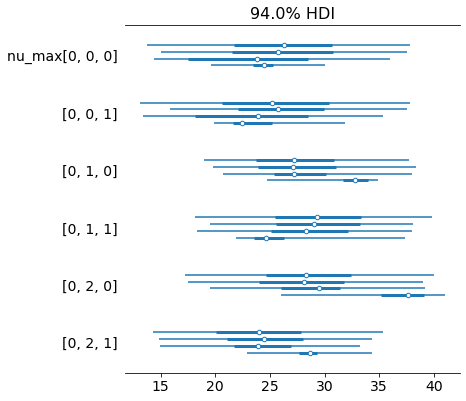

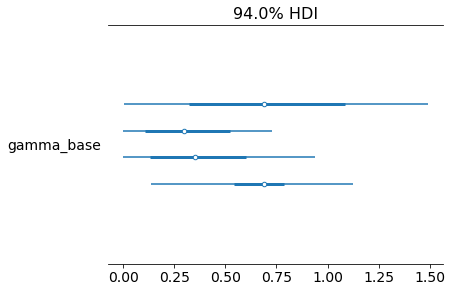

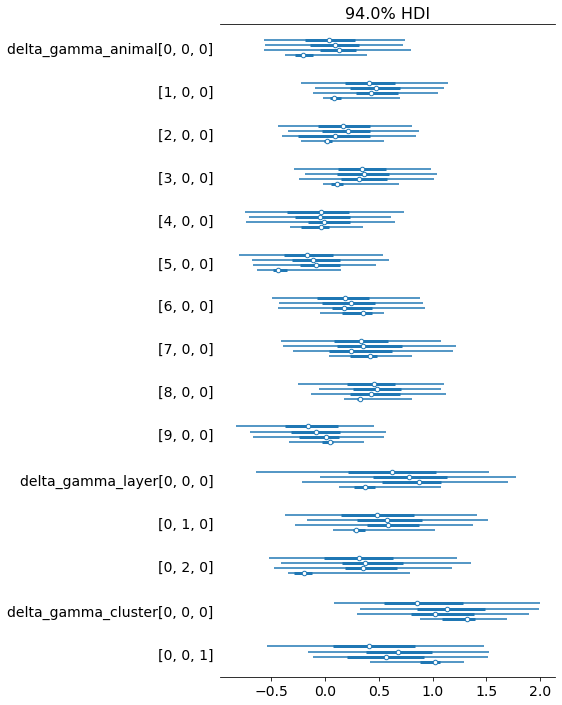

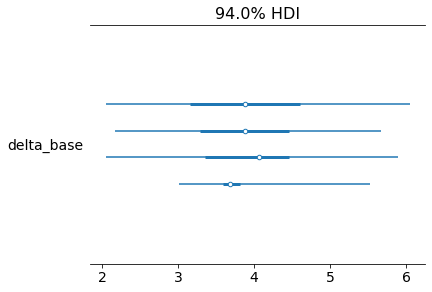

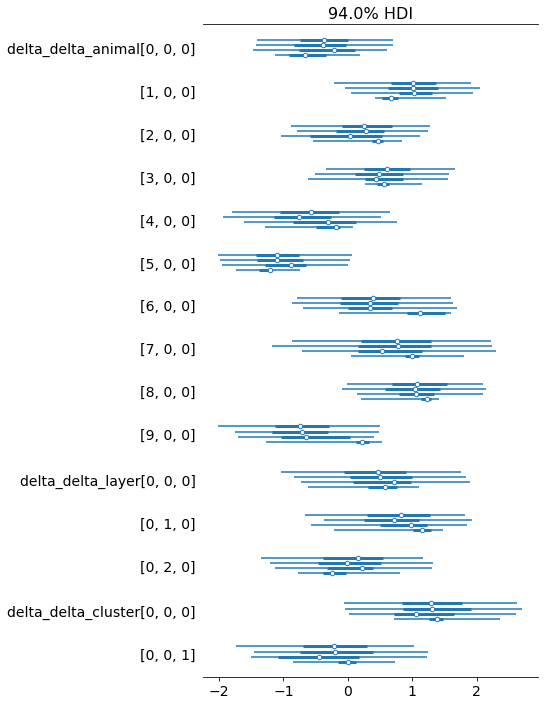

In [50]:
az.plot_forest(trace,var_names=['nu_max'])
az.plot_forest(trace,var_names=['gamma_base'])
az.plot_forest(trace,var_names=['^delta_gamma'], filter_vars='regex')
az.plot_forest(trace,var_names=['delta_base'])
az.plot_forest(trace,var_names=['^delta_delta'], filter_vars='regex')


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

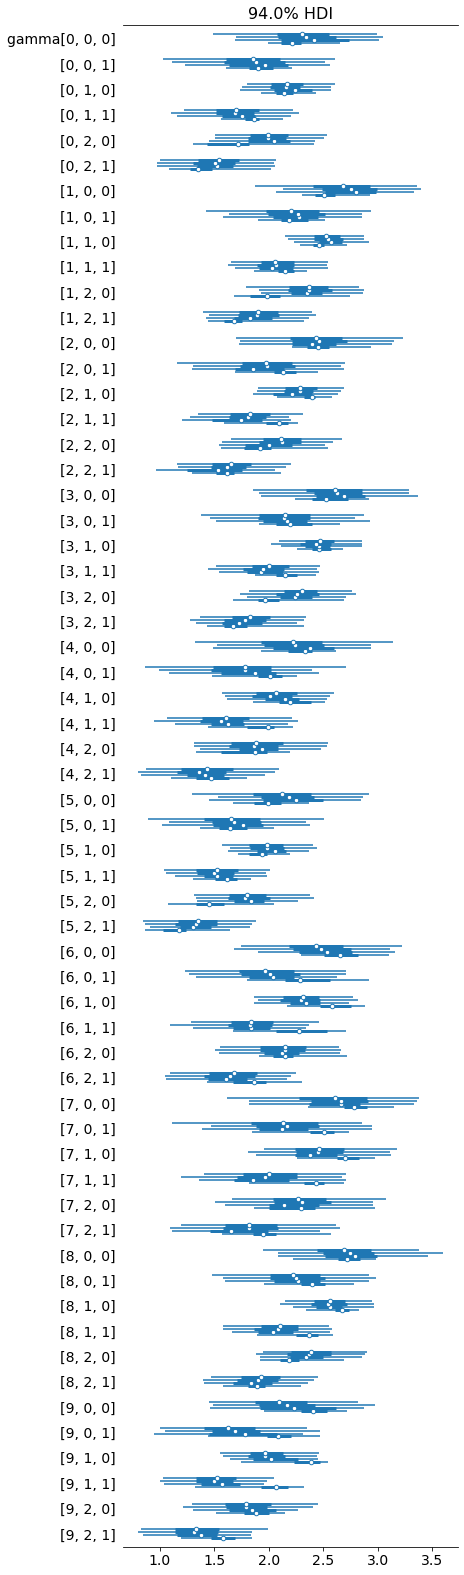

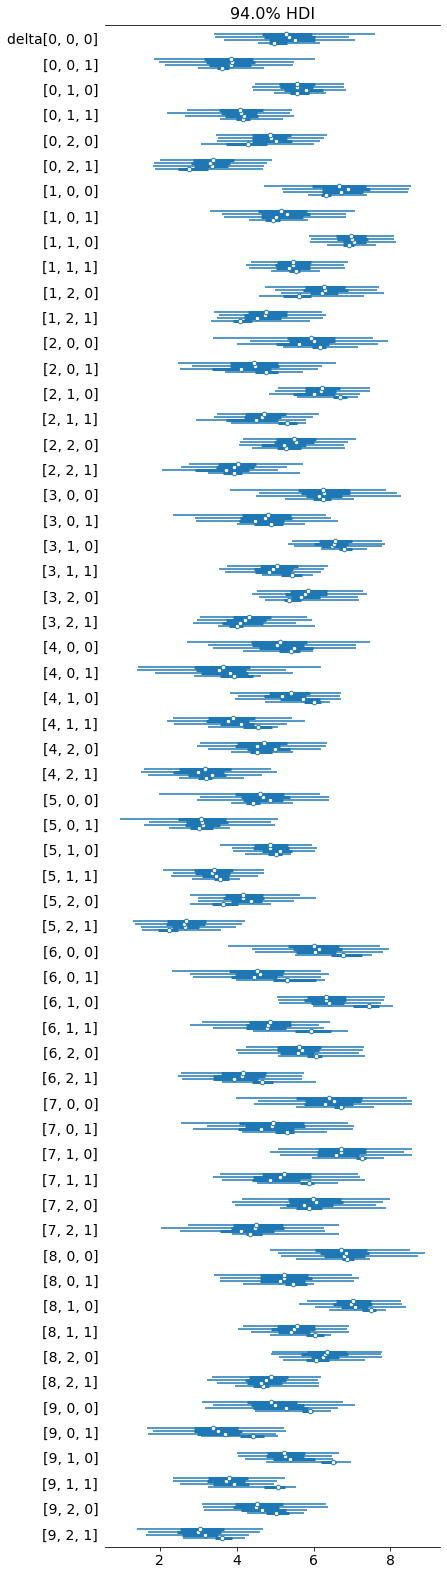

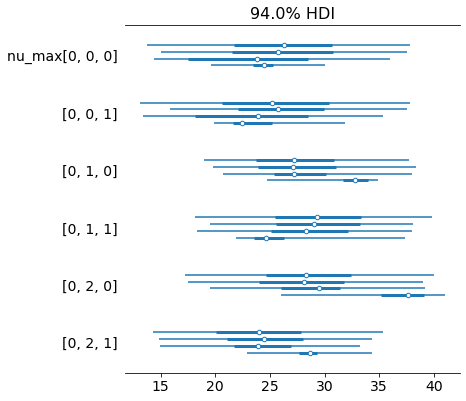

In [56]:
az.plot_forest(trace,var_names=['gamma'])
az.plot_forest(trace,var_names=['delta'])
az.plot_forest(trace,var_names=['nu_max'])

In [51]:
total_gamma = trace.posterior['gamma_base'].mean(axis=1) + \
    trace.posterior['delta_gamma_animal'].mean(axis=1) + \
    trace.posterior['delta_gamma_cluster'].mean(axis=1) + \
    trace.posterior['delta_gamma_layer'].mean(axis=1)
total_gamma.shape

(4, 10, 1, 1, 1, 1, 2, 1, 3, 1)

In [138]:
trace.posterior['gamma_base'].mean(axis=1) + np.array(trace.posterior['delta_gamma_cluster']).mean(axis=1)

ValueError: operands could not be broadcast together with shapes (4,) (4,1,1,2) 

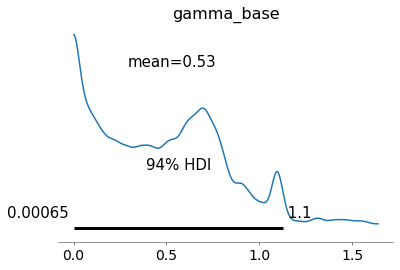

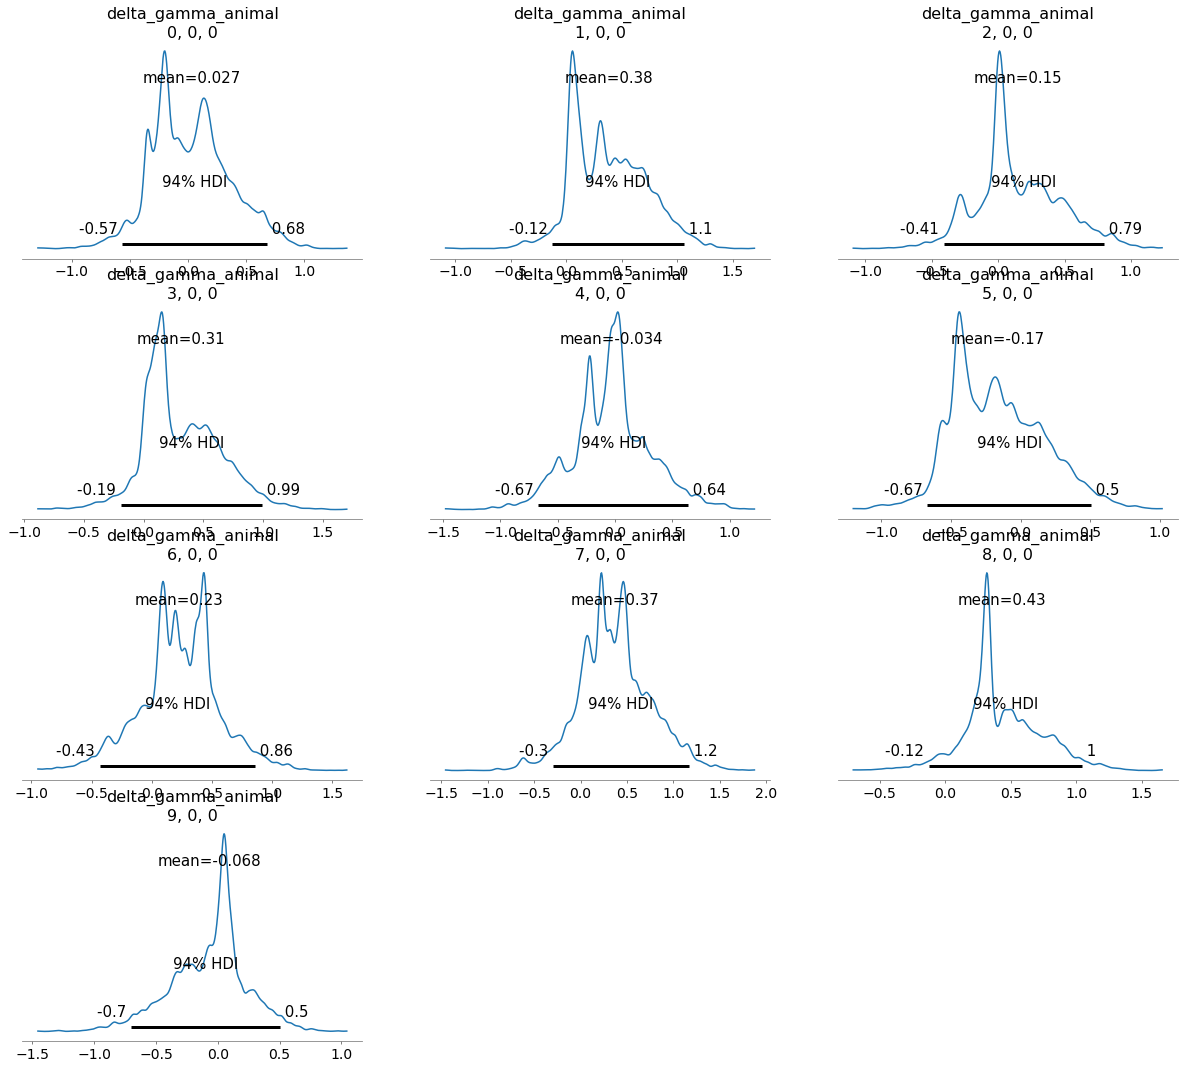

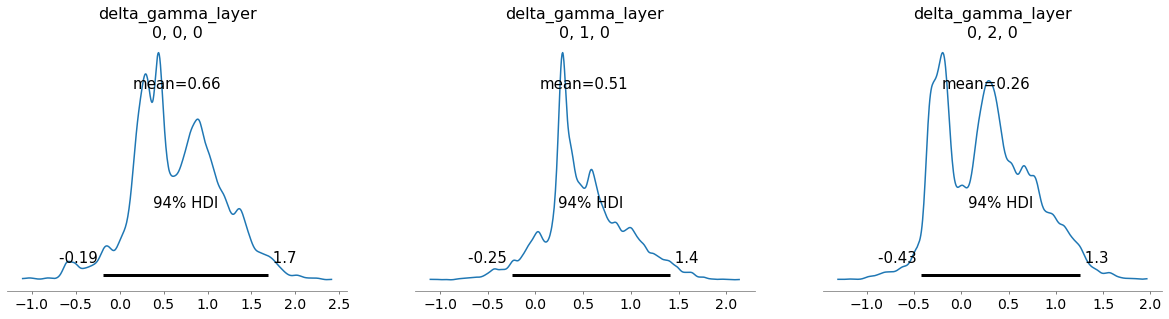

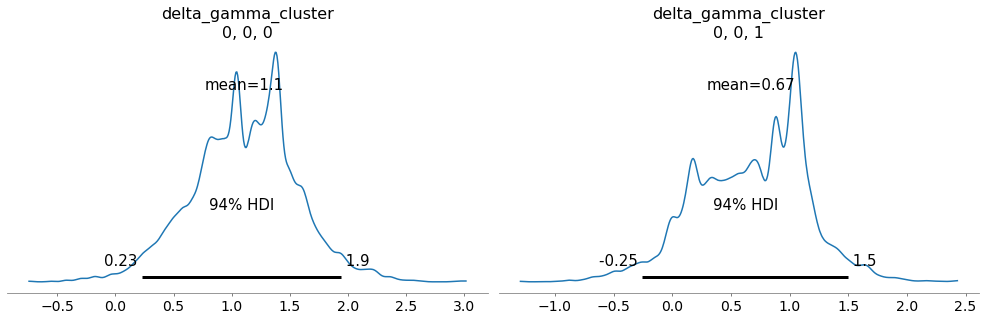

In [54]:
varName = 'gamma'
#az.plot_posterior(trace,var_names=[f'{varName}'])
az.plot_posterior(trace,var_names=[f'{varName}_base'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_animal'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_layer'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_cluster'],filter_vars='regex')
plt.tight_layout()

In [55]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"delta_gamma_animal[0, 0, 0]",0.03,0.34,-0.57,0.68,0.05,0.04,35.85,277.60,1.09
"delta_gamma_animal[1, 0, 0]",0.38,0.33,-0.12,1.06,0.06,0.04,29.90,556.20,1.10
"delta_gamma_animal[2, 0, 0]",0.15,0.32,-0.41,0.79,0.03,0.03,121.59,582.27,1.10
"delta_gamma_animal[3, 0, 0]",0.31,0.32,-0.19,0.99,0.04,0.03,84.57,959.07,1.04
"delta_gamma_animal[4, 0, 0]",-0.03,0.34,-0.67,0.64,0.02,0.03,291.60,591.77,1.08
...,...,...,...,...,...,...,...,...,...
"delta[9, 0, 1]",3.72,0.93,1.87,5.21,0.20,0.14,22.30,687.83,1.12
"delta[9, 1, 0]",5.56,0.79,4.18,6.87,0.23,0.17,12.91,84.04,1.22
"delta[9, 1, 1]",4.05,0.85,2.61,5.55,0.26,0.20,11.59,138.48,1.25
"delta[9, 2, 0]",4.70,0.78,3.12,6.03,0.10,0.07,66.73,297.29,1.07


In [180]:
model.deterministics

[sigma_gamma ~ HalfNormal,
 gamma_base ~ HalfNormal,
 sigma_delta ~ HalfNormal,
 delta_base ~ HalfNormal]